In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns

In [220]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor

In [221]:
d = extract.get_data()
d = extract.clean_data(d)

In [222]:
d.head()

,tradeid,cusip,amount,price,yield,tradedate,tradetype,name,state,coupon,maturity,issuesize,issuetype,issuesource,bidcount,rtg
0,317.0,45471AKG6,5000.0,99.507,4.037,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
1,318.0,45471AKG6,30000.0,99.410,4.045,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
2,319.0,45471AKG6,30000.0,99.290,4.054,0.0,Purchase_from_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
3,333.0,45471AMY5,15000.0,103.145,3.717,0.0,Sale_to_Customer,in fin auth-major,Indiana,4.25,6423.0,9520000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,9
4,378.0,4550572N8,150000.0,114.082,2.060,0.0,Sale_to_Customer,in fin auth-ref-a,Indiana,5.00,2894.0,22530000.0,REVENUE BONDS,WATER REVENUE,NaN,1


In [223]:
s0 = pd.read_csv("price_change_data.csv", usecols = ['d_index', 'tradetype',
		'state', 'coupon', 'maturity', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'dprice', 'holdtime'])

In [224]:
s0[:10]

,tradedate,tradetype,state,coupon,maturity,issuetype,issuesource,rtg,dprice,holdtime,d_index
0,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.762,1.0,0
1,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.376,1.0,0
2,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.473,6.0,0
3,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,1.614,8.0,0
4,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,1.272,10.0,0
5,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.211,21.0,0
6,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.126,21.0,0
7,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.306,27.0,0
8,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-2.240,29.0,0
9,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.665,1.0,1


In [225]:
d_index = s0.pop('d_index')
s_state_features = extract.build_state_features(s0, num_states = 20)
s_other_features = extract.build_other_text_features(s0)
s = pd.concat([s0.drop(['state', 'issuetype', 'issuesource', 'tradetype'], axis = 1), s_state_features, s_other_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < 7 days

In [226]:
s.head()

,tradedate,coupon,maturity,rtg,dprice,holdtime,Arizona,California,Connecticut,Dist. of Columbia,...,SPECIAL ASSESSMENT,SPECIAL TAX,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype
0,0.0,4.0,6635.0,6,-0.762,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,4.0,6635.0,6,0.376,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,4.0,6635.0,6,0.473,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0.0,4.0,6635.0,6,-0.665,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,0.0,4.0,6635.0,6,0.473,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Try a Random Forest Regressor

In [227]:
dprice = s.pop('dprice')

In [228]:
s_train, s_test, dp_train, dp_test = train_test_split(s, dprice, test_size=0.20, random_state=203)

### Want to optimize the max_depth and n_estimators parameters of the regressor with respect to the percentage of winning predictions that are actually winners. To do this, we construct a custom scorer function

In [229]:
def scorer(clf, X_test, y_test):
    #we want to maximize the recall of positive gains, i.e. the estimator catches the most positive outcomes
    y_predict = clf.predict(X_test)
    return float(np.sum(y_predict[y_test > 0] > 0))/np.sum(y_test > 0)

In [231]:
parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':[50, 100], 'criterion':['mse']}
rfr = RandomForestRegressor()
clf = GridSearchCV(rfr, param_grid = parameters, scoring = scorer)

In [232]:
clf.fit(s, dprice)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100], 'criterion': ['mse'], 'max_depth': [10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x7fd9a1318c08>, verbose=0)

In [233]:
clf.cv_results_
estimator = clf.best_estimator_
clf.best_params_

{'criterion': 'mse', 'max_depth': 20, 'n_estimators': 100}

In [234]:
dp_predict = estimator.predict(s_test)

In [235]:
dp_predict[:10]

array([-1.80688988, -2.52243784, -0.99426396, -0.56956658, -2.46786459,
       -2.14799485, -2.84120393, -1.66508455, -2.04197979, -3.68586655])

In [236]:
dp_test[:10]

30915   -1.185
6096    -2.545
73      -2.224
15324   -1.079
36687   -2.550
37439    0.608
16973   -3.569
34611   -0.229
6471    -2.273
49317   -3.580
Name: dprice, dtype: float64

In [237]:
I1 = dp_test > 0
np.sum(I1)
#scorer(estimator, s_test, dp_test)

547

### below: of the actual test cases where price increased, which fraction were predicted by the model to be an increase?

In [238]:
float(np.sum(dp_predict[I1] > 0))/np.sum(I1)

0.3820840950639854

In [239]:
I2 = (dp_test > 0) & (dp_predict > 0)
np.sum(I2)

209

### below: percentage of samples that were predicted by model to be increase and were actually an increase.

In [240]:
float(np.sum(I2))/np.sum(dp_predict > 0)

0.8708333333333333

### below: percentage of total predictions correct

In [241]:
float(np.sum((dp_predict>0) == (dp_test>0)))/dp_test.size

0.9300473933649289

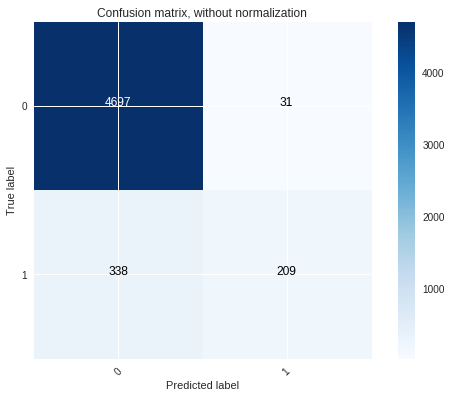

In [242]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

### For correctly predicted winners, what are typical values of dprice?

0.00299999999999 8.0 1.04853110048


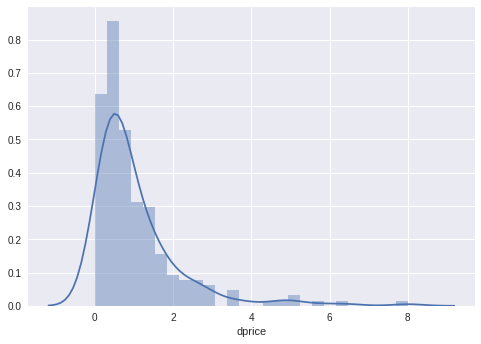

In [245]:
dp_slice = dp_test[I2]
print dp_slice.min(), dp_slice.max(), dp_slice.mean()
sns.distplot(dp_slice)
plt.show()

### Plot distribution of dprice_test when winner is predicted but it's actually a loser

-2.755 -0.00299999999999 -0.356857142857


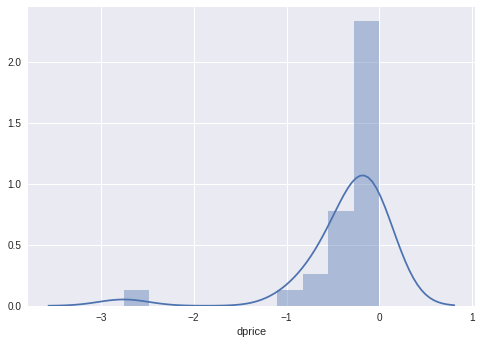

In [246]:
dp_slice_loser = dp_test[(dp_test < 0) & (dp_predict > 0)]
print dp_slice_loser.min(), dp_slice_loser.max(), dp_slice_loser.mean()
sns.distplot(dp_slice_loser)
plt.show()

In [247]:
clf.best_estimator_.feature_importances_

array([  2.10302861e-01,   1.11735397e-01,   2.42590932e-01,
         8.38366000e-02,   9.90696152e-02,   2.12538942e-03,
         7.85192027e-03,   2.41272706e-03,   9.08811729e-04,
         3.06472639e-03,   1.02139605e-03,   1.45894802e-02,
         1.51673685e-03,   3.78768419e-03,   6.77774507e-04,
         6.20978731e-04,   3.97054839e-03,   9.09676145e-03,
         1.04864813e-02,   5.78006433e-03,   6.39926849e-03,
         2.60172074e-03,   5.89297509e-03,   1.36028842e-02,
         1.16890847e-03,   8.40288512e-03,   2.01420612e-03,
         1.98044379e-03,   8.48322805e-03,   6.53459275e-03,
         9.00675666e-05,   1.62604080e-04,   3.83843041e-04,
         7.56971172e-03,   7.08992673e-03,   5.70506536e-04,
         0.00000000e+00,   8.61073243e-03,   8.56496213e-05,
         4.77979482e-03,   1.02015145e-04,   2.32892047e-03,
         2.66433223e-03,   6.87770321e-03,   7.15315364e-03,
         5.64897130e-03,   1.26946055e-04,   2.86554955e-03,
         7.78907564e-05,

In [248]:
important_features_indices = np.where(clf.best_estimator_.feature_importances_ > 0.01)
ordered_indices = sorted(range(s1.shape[1]), key=clf.best_estimator_.feature_importances_.__getitem__)
ordered_indices.reverse()
ordered_indices[:20]

[2, 0, 1, 4, 3, 72, 11, 23, 18, 17, 37, 28, 25, 71, 6, 33, 56, 44, 34, 61]

In [249]:
s_test.columns[ordered_indices[:20]]

Index([u'maturity', u'tradedate', u'coupon', u'holdtime', u'rtg',
       u'TOBACCO SETTLEMENT FUNDED', u'Illinois', u'Virgin Islands', u'Ohio',
       u'New York', u'COLLEGE & UNIV. REV.', u'GENERAL OBLIGATION UNLTD',
       u'otherstates', u'TOBACCO & LIQUOR TAXES', u'California',
       u'AD VALOREM PROPERTY TAX', u'MISCELLANEOUS REVENUE',
       u'HIGHWAY REVENUE TOLLS', u'APPROPRIATIONS',
       u'PRT, AIRPRT & MARINA REV.'],
      dtype='object')

In [250]:
clf.best_estimator_.feature_importances_[ordered_indices[:20]]

array([ 0.24259093,  0.21030286,  0.1117354 ,  0.09906962,  0.0838366 ,
        0.01925886,  0.01458948,  0.01360288,  0.01048648,  0.00909676,
        0.00861073,  0.00848323,  0.00840289,  0.00786889,  0.00785192,
        0.00756971,  0.00718582,  0.00715315,  0.00708993,  0.0070226 ])